<a id="top"></a>
# **Song BPM Prediction | LGBM | KFold**

By Conrad Kleykamp

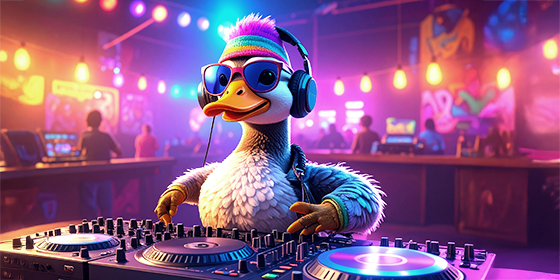

Table of Contents:
- [About the Project](#1)
- [About the Data](#2)
- [Set Up](#3)
- [Exploratory Data Analysis](#4)
    - [Overview](#4.1)
    - [Target Variable: BeatsPerMinute](#4.2)
    - [Numeric Features](#4.3)
    - [Interactions](#4.4)
- [Data Preprocessing](#5)
    - [Feature Engineering](#5.1)
    - [Preparing for Modeling](#5.2)
- [LGBM](#6)
    - [LGBM with KFold](#6.1)
    - [Tuned LGBM with Optuna (OPTIONAL)](#6.2)
    - [Model Evaluation](#6.3)
    - [Model Version Notes](#6.4)
- [Conclusion/Discussion](#c) 
- [Submission](#s)
- [References](#r)
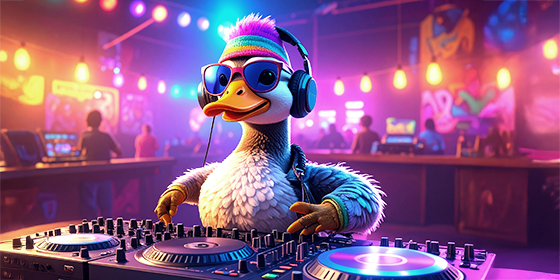

<a id="top"></a>

<a href="#2" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="1"></a>
# **1) About the Project**

---

This notebook has been completed as part of Kaggle's Playground Prediction Competition [Predicting the Beats-per-Minute of Songs](https://www.kaggle.com/competitions/playground-series-s5e9/overview). 

I have created this notebook to provide a simple, understandable solution. As with most of my work on Kaggle, I try to explain each line of code so that anyone, from budding data scientist to machine learning pro, can understand my process and hopefully learn something new. 

The overarching goal of this project is to predict a song's beats per minute (BPM). In music, tempo is the speed or pace of a given composition and is measured in BPM. For example, a song with 60 BPM has one beat per second, while a song with 120 BPM has two beats per second. 

As BPM is represented by a numeric value, this project is thus a regression task, i.e. the goal is to predict a continuous numeric value based upon the given independent features. Regression problems can be solved by utilizing supervised learning techniques such as linear regression, support vector machines, decision trees, random forests, and ensemble learning. 

The model I have selected for this project is [Light Gradient Boosting Machine](https://lightgbm.readthedocs.io/en/latest/index.html) (LGBM). LGBM is an ensemble learning framework that leverages multiple decision trees and gradient boosting. LGBM works by growing leaves with the highest loss reduction and thus sequentially minimizes loss using gradient descent. LGBM is an excellent tool for tabular data problems and I have enjoyed using it for various regression and classification tasks.  

The evaluation metric used for this project and competition is the [Root Mean Squared Error](https://en.wikipedia.org/wiki/Root_mean_square_deviation) (RMSE). This is a typical metric used for evaluating the predictive performance of regression models. The goal here is to MINIMIZE this value. 

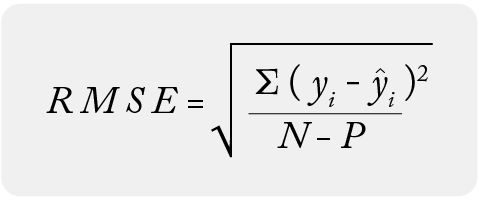

The general structure/pipeline of this project is as follows:

- Set up & data loading
- Exploratory data analysis (viewing distributions and interactions)
- Data preprocessing (cleaning, removing outliers, feature engineering)
- Modeling (cross validation with KFold)

I hope you enjoy this project! If you have any comments, questions, criticism, or recommendations, please let me know. I'm always eager to continue to refine my data skills and learn from this community. 
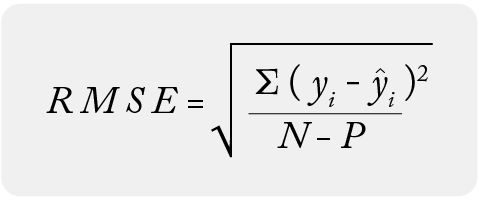

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#3" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="2"></a>
# **2) About the Data**

---

The data used in this project is synthetically generated tabular data provided by Kaggle. This data was generated from the original [BPM Prediction Challenge](https://www.kaggle.com/datasets/gauravduttakiit/bpm-prediction-challenge) dataset. 

Typically, as mentioned by Kaggle, the feature distributions of both the original and synthetic data are roughly similar, but not exactly the same. In past competitions, I have used [adversarial validation](https://blog.zakjost.com/post/adversarial_validation/) to test the degree of difference between the original and Kaggle datasets. 

For this particular project, I wanted to streamline my notebook and thus have not included adversarial validation. However, I did complete this behind the scenes and found that the datasets had significantly different feature distributions (AUC-ROC ~0.86). Because of this, I have opted to not include the original data in this project. However, training a model with more robust data (different distributions) may help generalize performance on novel/test data. 

**Target Variable:**
- BeatsPerMinute

**Features:** 
- id
- RhythmScore
- AudioLoudness
- VocalContent
- AcousticQuality
- InstrumentalScore
- LivePerformanceLikelihood
- MoodScore
- TrackDurationMs
- Energy

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#4" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="3"></a>
# **3) Set Up**

---

In [1]:
# Importing and loading necessary libraries and packages

# Fundamental libraries
import pandas as pd
import numpy as np

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'Set2')
pal = sns.color_palette('Set2')

# Scipy
from scipy.stats import skew, zscore

# Catboost
import catboost
from catboost.utils import eval_metric

# Sklearn
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

# LightGBM
import lightgbm as lgb
from lightgbm import plot_importance

# Shap
import shap
shap.initjs()

# Optuna
import optuna

In [2]:
# Loading in the Kaggle datasets
df_train = pd.read_csv('/kaggle/input/playground-series-s5e9/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e9/test.csv')

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#5" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="4"></a>
# **4) Exploratory Data Analysis**

---

The following sections will use the 'eda' function (see below). This function performs a brief exploratory data analysis and can be applied to any numeric feature/target. 

The 'eda' function does the following:
- Prints skewness
- Detects outliers (either using IQR or Z-score)
- Plots a boxplot and histogram with outliers highlighted
- Returns a table of summary statistics

Skewness is a measure of the symmetry of the distribution of data, i.e. how the data is spread out. This measure can help us identify outliers. A skewness of 0 indicates that the distribution is perfectly symmetrical (think normal distribution). A negative skewness indicates that most of the data values are on the right side (along the x-axis of a graph), with a tail (fewer values) on the left side. A positive skewness indicates that most of the data values are on the left side, with a tail on the right side. 

Outliers are data points that deviate significantly from the general observations. These can take on values that are much higher or lower than typical. In some cases, outliers represent noise, anomalies, or errors that can negatively impact the performance of a predictive model. Because of this, it is often beneficial to identify and remove outliers before building a model. However, including some outliers can sometimes enable a model to produce more robust predictions.

Outliers can be detected using several methods, such as the interquartile range (IQR) and Z-score. The IQR represents the statistical middle 50% of the data and anything outside of this range is considered an outlier. The Z-score (or standard score) tells us how many standard deviations away a data point is from the mean. In this case, if a data point is ~3 standard deviations away from the mean, it is considered an outlier. 

The function I have provided can utilize either IQR or Z-score to identify outliers. Feel free to play around with both.

<a id="top"></a>
<a id="4.1"></a>
## **4.1) Overview**

In [3]:
# Viewing the first 5 rows in df_train
df_train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [4]:
# Viewing the info of df_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB


### **Shape of the Training Data**
- 524,164 rows
- 11 columns
    - id (int64)
    - BeatsPerMinute (target)
    - 9 features (float64)

### **Nulls/Missing Values**
- None! (This dataset is precleaned thanks to Kaggle)

### **Test Data**
- Not pictured to streamline notebook
- 174,722 rows
- 10 columns
    - id (int64)
    - 9 features (float54)

<a id="top"></a>
<a id="4.2"></a>
## **4.2) Target Variable: BeatsPerMinute**

In [5]:
# Creating eda function (can be applied to both target variable and feature variables)

def eda(df, columns, method='iqr', z_thresh=3, plot=True):
    """
    This function performs exploratory data analysis on a given numeric feature/target:
    - Prints skewness
    - Detects outliers (IQR or Z-score)
    - Plots boxplot and histogram with outliers highlighted
    - Returns summary statistics with outlier info
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        columns (str or list): Column(s) to analyze
        method (str): 'iqr' or 'zscore'
        z_thresh (float): Z-score threshold
        plot (bool): Whether to show boxplot + histogram
    """
    if isinstance(columns, str):
        columns = [columns]  # make it a list for uniform handling
    
    summaries = []
    
    for column in columns:
        data = df[column].dropna()
        skewness = data.skew()
        
        # Detect outliers
        if method == 'iqr':
            Q1, Q3 = data.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
            outliers = data[(data < lower) | (data > upper)]
        elif method == 'zscore':
            z_scores = zscore(data)
            outliers = data[abs(z_scores) > z_thresh]
        else:
            raise ValueError("Method must be 'iqr' or 'zscore'")
        
        print(f"\n=== {column} ===")
        print(f"Skewness: {skewness:.4f}")
        print(f"Detected {len(outliers)} outliers using {method} method.")
        
        # Visualization (optional)
        if plot:
            
            plt.figure(figsize=(12,5))
            
            # Boxplot
            plt.subplot(1,2,1)
            sns.boxplot(x=data)
            plt.scatter(outliers, [0]*len(outliers), color='red', label='Outliers')
            plt.title(f'Boxplot of {column}')
            plt.legend()
            
            # Histogram
            plt.subplot(1,2,2)
            sns.histplot(data, bins=30, kde=True)
            for outlier in outliers:
                plt.axvline(outlier, color='red', linestyle='--', alpha=0.5)
            plt.title(f'Histogram of {column}')
            
            plt.tight_layout()
            plt.show()
        
        # Collect summary
        summaries.append({
            "column": column,
            "count": len(data),
            "mean": data.mean(),
            "median": data.median(),
            "std": data.std(),
            "min": data.min(),
            "max": data.max(),
            "skewness": skewness,
            "num_outliers": len(outliers),
            "pct_outliers": len(outliers) / len(data) * 100
        })
    
    return pd.DataFrame(summaries)


=== BeatsPerMinute ===
Skewness: 0.0715
Detected 505 outliers using zscore method.


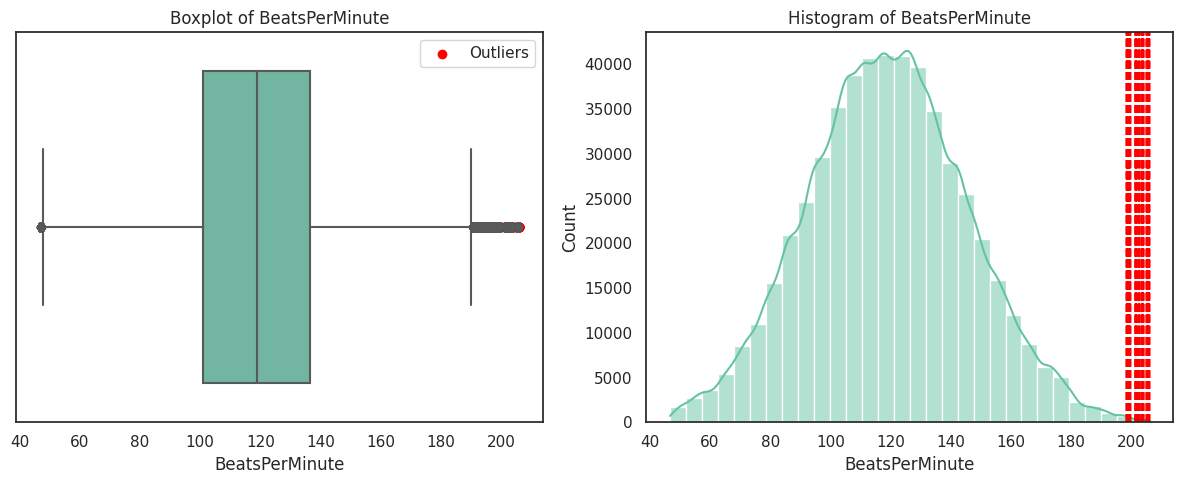

,column,count,mean,median,std,min,max,skewness,num_outliers,pct_outliers
0,BeatsPerMinute,524164,119.034899,118.74766,26.468077,46.718,206.037,0.07155,505,0.096344


In [6]:
# Applying eda function to 'BeatsPerMinute'
eda(df_train, 'BeatsPerMinute', method='zscore', plot=True)

### **BeatsPerMinute Summary**

- Mean BPM: 119.03
- Min BPM: 46.72
- Max BPM: 206.04
- Skewness: 0.07155
- Outliers (IQR): 2141
- Outliers (Z-score): 505

<a id="top"></a>
<a id="4.3"></a>
## **4.3) Numeric Features**

In [7]:
# Declaring numeric features
data_numeric = df_train.drop(['BeatsPerMinute', 'id'], axis=1)
features = data_numeric.columns

In [8]:
# Applying eda function to numeric features
eda(df_train, features, method='iqr', plot=False)


=== RhythmScore ===
Skewness: 0.1682
Detected 8 outliers using iqr method.

=== AudioLoudness ===
Skewness: -0.3085
Detected 1770 outliers using iqr method.

=== VocalContent ===
Skewness: 0.7891
Detected 1245 outliers using iqr method.

=== AcousticQuality ===
Skewness: 0.7860
Detected 6746 outliers using iqr method.

=== InstrumentalScore ===
Skewness: 1.0363
Detected 2845 outliers using iqr method.

=== LivePerformanceLikelihood ===
Skewness: 0.3933
Detected 129 outliers using iqr method.

=== MoodScore ===
Skewness: -0.2688
Detected 0 outliers using iqr method.

=== TrackDurationMs ===
Skewness: -0.1905
Detected 4267 outliers using iqr method.

=== Energy ===
Skewness: -0.0303
Detected 0 outliers using iqr method.


,column,count,mean,median,std,min,max,skewness,num_outliers,pct_outliers
0,RhythmScore,524164,0.632843,0.634686,0.156899,0.076900,0.975000,0.168155,8,0.001526
1,AudioLoudness,524164,-8.379014,-8.252499,4.616221,-27.509725,-1.357000,-0.308514,1770,0.337681
2,VocalContent,524164,0.074443,0.066425,0.049939,0.023500,0.256401,0.789112,1245,0.237521
3,AcousticQuality,524164,0.262913,0.242502,0.223120,0.000005,0.995000,0.785966,6746,1.287002
4,InstrumentalScore,524164,0.117690,0.074247,0.131845,0.000001,0.869258,1.036285,2845,0.542769
5,LivePerformanceLikelihood,524164,0.178398,0.166327,0.118186,0.024300,0.599924,0.393322,129,0.024611
6,MoodScore,524164,0.555843,0.564817,0.225480,0.025600,0.978000,-0.268820,0,0.000000
7,TrackDurationMs,524164,241903.692949,243684.058150,59326.601501,63973.000000,464723.228100,-0.190483,4267,0.814058
8,Energy,524164,0.500923,0.511800,0.289952,0.000067,1.000000,-0.030344,0,0.000000


### **Numeric Features Summary**

From the brief EDA above, we can see that many of the features have values on a scale of 0-10, i.e. RhythmScore, AcousticQuality, InstrumentalScore, LivePerformanceLikelihood, MoodScore, Energy.

In terms of outliers, only one feature (AcousticQuality) had greater than 1% outliers. 

**Notable Skewness**
- VocalContent (0.7891)
- AcousticQuality (0.7860)
- InstrumentalScore (1.0363)

**Notable Outliers**
- AcousticQuality: 1.15% (Z-score), 1.29% (Z-score)

<a id="top"></a>
<a id="4.4"></a>
## **4.4) Interactions**

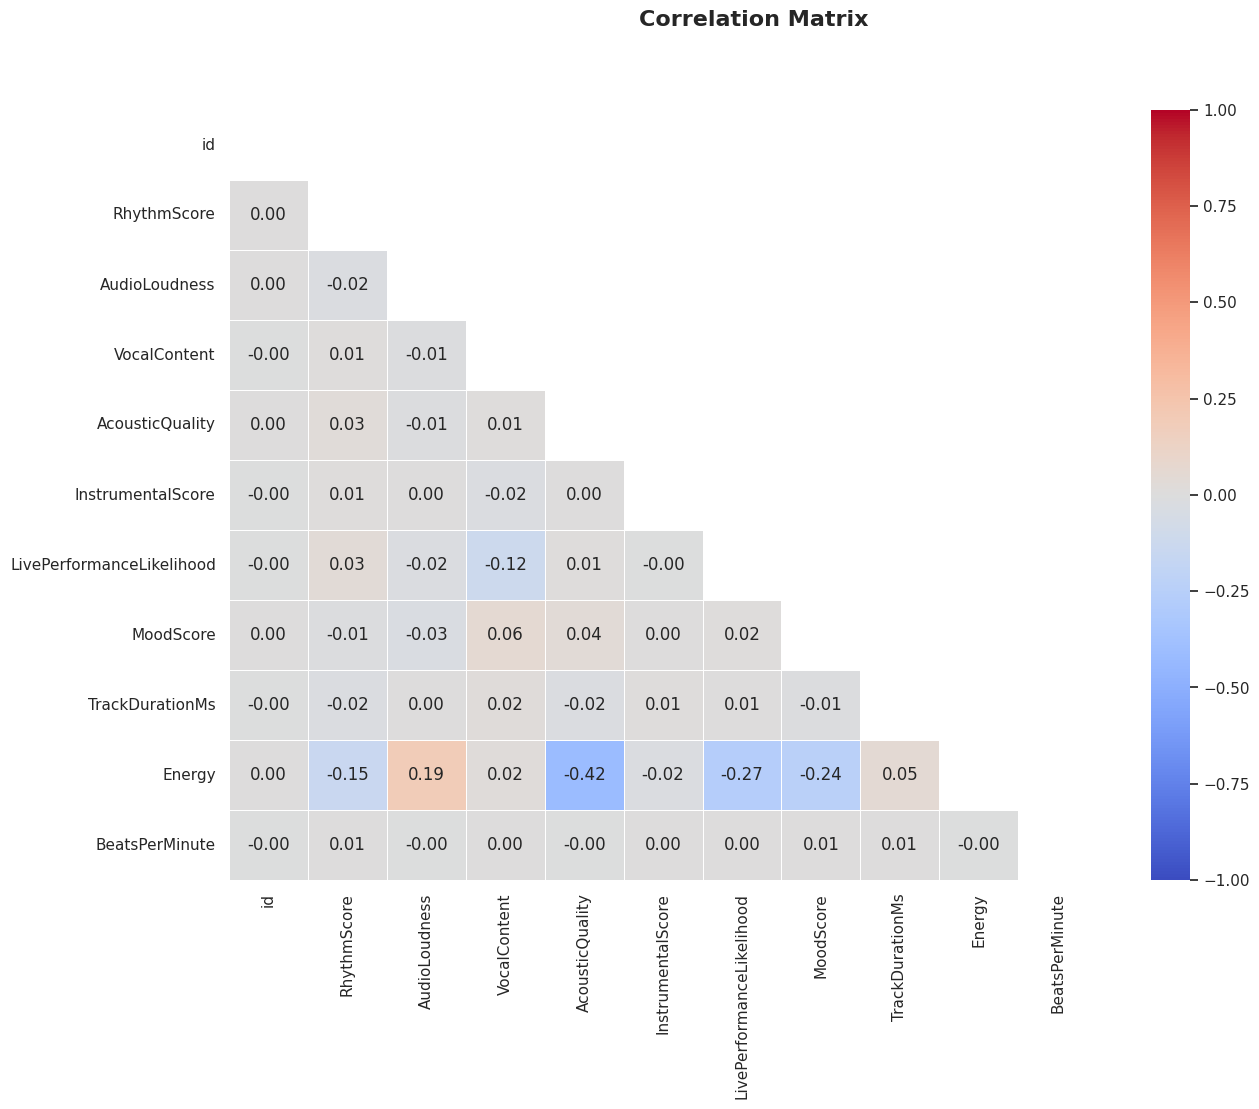

In [9]:
# Visualizing correlation matrix of numeric features and target variable in training data
plt.figure(figsize=(14,10))
corr=df_train.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm', linewidths=0.5, fmt=',.2f', vmax=1, vmin=-1, center=0, mask=np.triu(corr))
plt.suptitle('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

### **Interactions Summary**

The correlation heatmap/matrix above shows the correlation strength between each feature (or target) pair. Dark red tones (values close to 1.0) signify a strong positive linear correlation between two features, i.e. as one feature increases in value, so does the other. Dark blue tones (values close to -1.0) signify a strong negative linear correlation, i.e. as one feature increases in value, the other decreases. Correlation values close to 0.0 suggest that there is no linear relationship between the variables.

As shown above, almost all of the cells show no significant correlation. This suggests that there is likely no linear relationship among features. Furthermore, the target variable BeatsPerMinute has no significant correlation to any feature. 

The only noteworthy correlation shown is a moderate negative correlation (-0.42) between Energy and AcousticQuality. This suggests that as the Energy of a song increases, the AcousticQuality may decrease. 

### **EDA Conclusion**

**Skewness**

The significant positive skewness of VocalContent, AcousticQuality, and InstrumentalScore may need to be addressed in the Data Preprocessing step (below). Common strategies for combating skewness include transformations such as log and square root. A log transformation is particularly suited for significantly right skewed data. A square root transformation is suited for moderately right skewed data. 

Suggested transformations:
- InstrumentalScore --> log
- VocalContent --> square root
- AcousticQuality --> square root

**Outliers**

As mentioned above, outliers have the potential to harm a model's predictive power. Moving forward, we can remove the detected outliers computed via either the IQR or Z-score. I will be sure to try each method independently in my Data Preprocessing step and see which technique elicits a better RMSE.

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#6" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="5"></a>
# **5) Data Preprocessing**

---

<a id="top"></a>
<a id="5.1"></a>
## **5.1) Feature Engineering**

In [10]:
def preprocess_and_engineer(df, method='zscore', is_train=True):
    
    # Making a fresh copy of the data
    df = df.copy()
    
    # --- Handling missing values (median imputation) ---
    # Not needed for this particular dataset but handy to have in general
    for col in df.columns:
        if df[col].dtype in ['float64']:
            df[col] = df[col].fillna(df[col].median())
    
    # --- Outlier handling (IQR or Z-score) ---
    # TRAIN ONLY, DO NOT APPLY TO TEST SET
    if is_train:
        # IQR method
        if method == 'iqr':
            num_cols = df.select_dtypes(include=['float64']).columns
            for col in num_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        # Zscore method
        elif method == 'zscore':
            num_cols = df.select_dtypes(include=['float64']).columns
            z_scores = df[num_cols].apply(zscore)
            df = df[(z_scores.abs() <= 3).all(axis=1)]
        # No outlier removal method
        else:
            pass

    # --- Transformations of features with high skewness ---
    # 'LogTrackDuration' --> Skew: 1.0363
    df['TrackDurationMs'] = np.log1p(df['TrackDurationMs'])
    # 'VocalContent' --> Skew: 0.7891
    df['VocalContent'] = np.sqrt(df['VocalContent'])
    # 'AcousticQuality' --> 0.7860
    df['AcousticQuality'] = np.sqrt(df['AcousticQuality'])
    
    # --- New features ---
    # Time-based features
    df['TrackDurationMin'] = df['TrackDurationMs'] / 60000
    df['RhythmPerMs'] = df['RhythmScore'] / (df['TrackDurationMs'] + 1)
    # Interactions
    df['LoudnessEnergy'] = df['AudioLoudness'] * df['Energy']
    df['RhythmEnergy'] = df['RhythmScore'] * df['Energy']
    df['AcousticVocal'] = df['AcousticQuality'] * df['VocalContent']
    df['MoodLive'] = df['MoodScore'] * df['LivePerformanceLikelihood'] 
    # Ratios
    # Establishing min_val to preserve magnitude of ratios
    min_val = 1e-3
    df['InstrVocalRatio'] = df['InstrumentalScore'] / df['VocalContent'].clip(lower=min_val)
    df['EnergyRhythmRatio'] = df['Energy'] / df['RhythmScore'].clip(lower=min_val)
    df['VocalAcousticRatio'] = df['VocalContent'] / df['AcousticQuality'].clip(lower=min_val)
    
    # --- Quantile rank features ---
    for col in ['Energy', 'MoodScore', 'TrackDurationMs']:
        df[f'{col}_Rank'] = df[col].rank(pct=True)
    
    return df

# Applying function to df_train and df_test
train = preprocess_and_engineer(df_train, method='', is_train=True)
test = preprocess_and_engineer(df_test, method='', is_train=False)

In [11]:
# Verifying changes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
 11  TrackDurationMin           524164 non-null  float64
 12  RhythmPerMs                524164 non-null  float64
 13  LoudnessEnergy             52

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         174722 non-null  int64  
 1   RhythmScore                174722 non-null  float64
 2   AudioLoudness              174722 non-null  float64
 3   VocalContent               174722 non-null  float64
 4   AcousticQuality            174722 non-null  float64
 5   InstrumentalScore          174722 non-null  float64
 6   LivePerformanceLikelihood  174722 non-null  float64
 7   MoodScore                  174722 non-null  float64
 8   TrackDurationMs            174722 non-null  float64
 9   Energy                     174722 non-null  float64
 10  TrackDurationMin           174722 non-null  float64
 11  RhythmPerMs                174722 non-null  float64
 12  LoudnessEnergy             174722 non-null  float64
 13  RhythmEnergy               17

<a id="top"></a>
<a id="5.2"></a>
## **5.2) Preparing for Modeling**

In [13]:
# Creating fresh copies of train and test sets
train = train.copy()
test = test.copy()

In [14]:
# Splitting train data into X and y
X = train.drop(columns=['BeatsPerMinute', 'id'])
y = train['BeatsPerMinute']
X_test = test.drop(['id'], axis=1)

# Splitting the train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#7" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="6"></a>
# **6) LGBM**

---

<a id="top"></a>
<a id="6.1"></a>
## **6.1) Baseline LGBM with KFold**

The code chunk below builds a baseline (manually imputed parameter values) LGBM model and stress-tests it with KFold. [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) is a commonly used tool that can be used to evaluate a model's performance more reliably. Instead of using one train/validation split, the data is divided into k equal parts (folds, in this case 5). The model is trained on k-1 folds and then validated on the remaining fold, and this process is repeated until every fold has been used for validation. The results are then averaged, which helps prevent the model from overfitting on a single validation set.

**LGBM Model Parameters:**
- **n_estimators** --> essentially the number of boosting iterations
- **learning_rate** --> shrinkage rate, very small step size, stable but slower training
- **num_leaves** --> this controls the maximum number of leaves in each tree, higher values create more complex trees but may overfit, lower values create simpler tree but may underfit
- **max_depth** --> this limits the max depth of the tree model, deeper trees can capture more complex patterns but may also overfit
- **min_child_samples** --> the minimal number of data in one tree leaf, helps with over-fitting
- **subsample** --> similar to "colsample_bytree" but randomly selects part of the data without resampling, can also be used to speed up training
- **colsample_bytree** --> this helps speed up training and potentially deal with over-fitting
- **reg_alpha & reg_lambda** --> aliases for lambda_l1 & lambda_l2, L1 & L2 regularization
- **random_state = 42** --> this sets a random state which can be used for reproducing specific results
- **verbosity = -1** --> this lowers the verbosity (amount of text generated) of the LightGBM model
- **boosting_type = 'gbdt'** --> this sets the boosting type to traditional gradient boosting decision tree
- **metric = 'rmse'** --> the evaluation metric (root mean squared error)

In [15]:
# =========================================
# Baseline LGBM + KFold
# =========================================

# --- If using the baseline LGBM (no tuned hyperparameters), set run_lgbm to 1, otherwise 0 to skip ---
run_lgbm = 1

if run_lgbm == 1:
    
    print("=== Running Baseline LGBM + KFold ===")
    # Creating KFold cross validation with 5 splits
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initializing array to store predictions, lists to store each model and validation RMSEs
    y_preds = np.zeros(len(X_test))
    models = []
    val_rmses = []
    
    # Looping through each fold created by KFold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        # Printing fold progress
        print(f"Training fold {fold + 1}/{n_splits} >>>")
        # Splitting the data into training and validation sets for each current fold
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
        # Defining baseline LGBM parameters
        model = lgb.LGBMRegressor(
            n_estimators=20000,
            learning_rate=0.001,
            num_leaves=100,
            max_depth=10,
            min_child_samples=10,
            subsample=1.0,
            colsample_bytree=1.0,
            reg_alpha=2.0,
            reg_lambda=1.0,
            random_state=42,
            verbosity=-1,
            boosting_type='gbdt',
            metric='rmse'
        )
    
        # Fitting LGBM model on training data, evaluating with validation data
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            # Stopping training if validation doesn't improve for 100 rounds
            # Logging validation metrics every 100 iterations
            callbacks=[
                lgb.early_stopping(100),
                lgb.log_evaluation(period=100)
            ]
        )
        
        # Saving model 
        models.append(model)
    
        # Making predictions on test set for current fold (average prediction across all models)
        y_preds += model.predict(X_test) / n_splits
        # Making predictions on validation data
        val_pred = model.predict(X_val)
        val_rmse = mean_squared_error(y_val, val_pred, squared=False)
        val_rmses.append(val_rmse)
    # Printing average validation RMSE across folds
    print(f"Mean RMSE: {np.mean(val_rmses):.6f}")

=== Running Baseline LGBM + KFold ===
Training fold 1/5 >>>
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 26.4435
[200]	valid_0's rmse: 26.4419
[300]	valid_0's rmse: 26.4409
[400]	valid_0's rmse: 26.4402
[500]	valid_0's rmse: 26.4399
[600]	valid_0's rmse: 26.4397
[700]	valid_0's rmse: 26.4397
Early stopping, best iteration is:
[650]	valid_0's rmse: 26.4397
Training fold 2/5 >>>
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 26.4906
[200]	valid_0's rmse: 26.489
[300]	valid_0's rmse: 26.4876
[400]	valid_0's rmse: 26.4865
[500]	valid_0's rmse: 26.4859
[600]	valid_0's rmse: 26.4856
[700]	valid_0's rmse: 26.4854
[800]	valid_0's rmse: 26.4853
[900]	valid_0's rmse: 26.4852
Early stopping, best iteration is:
[875]	valid_0's rmse: 26.4852
Training fold 3/5 >>>
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 26.5302
[200]	valid_0's rmse: 26.5287
[300]	valid_0's rmse: 26.5274
[400]	valid

<a id="top"></a>
<a id="6.2"></a>
## **6.2) Tuned LGBM with Optuna (OPTIONAL)**

This section builds a LGBM model with parameter values tuned by Optuna. [Optuna](https://optuna.org/) is a hyperparameter optimization framework that can be used to automate the discovery of optimal parameter values. When run_optuna is set to 1, Optuna will work through the suggested parameter values and determine the optimal values. These parameter values can then be manually saved and plugged into a LGBM model with KFold.

This step is entirely optional and may or may not improve the final RMSE score. Please note that while the best parameters can be saved and used again, the Optuna trials should be run again whenever the data preprocessing/feature engineering steps have changed.  

If there are no changes to the training data, run_optuna can be set to 0 and the recorded best_params_1 can be utilized in the final model. This will drastically cut down on the runtime of this notebook.

In [16]:
# =========================================
# Optional Optuna-tuned LGBM + KFold
# =========================================

# --- If using the tuned LGBM (with Optuna), set run_optuna to 1, otherwise 0 to skip ---
# NOTE: This only has to run once, you can record the resulting best_params (below) and set use_optuna_params to 1
run_optuna = 0  

if run_optuna == 1:
    
    print("=== Running LGBM Tuned with Optuna ===")
    # Defining objective, suggesting parameter value ranges
    def objective(trial):
        params = {
            "n_estimators": 20000,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 20, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            "random_state": 42,
            "verbosity": -1,
            "boosting_type": "gbdt",
            "metric": "rmse"
        }

        val_rmses = []
        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
            )

            preds = model.predict(X_val)
            rmse = mean_squared_error(y_val, preds, squared=False)
            val_rmses.append(rmse)

        return np.mean(val_rmses)

    # Running Optuna study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    print("Best params from Optuna:", study.best_params)
    print("Best RMSE from Optuna:", study.best_value)

In [17]:
# Saving best parameters from Optuna trials (above)
# Once saved, these can be plugged in below to the final LGBM model
best_params_1 = {'learning_rate': 0.0025770920018536995, 
                 'num_leaves': 220, 
                 'max_depth': 6, 
                 'min_child_samples': 85, 
                 'subsample': 0.6333262521157302, 
                 'colsample_bytree': 0.5464230684325477, 
                 'reg_alpha': 2.7317532956083355, 
                 'reg_lambda': 2.766633462787757}

In [18]:
# =========================================
# Optional Optuna-tuned LGBM + KFold (CONTINUED)
# =========================================

# This section uses the recorded best_params_1 and builds a LGBM model and stress tests it with KFold

# --- If using the tuned LGBM (with Optuna), set use_optuna_params to 1, otherwise 0 to skip ---
use_optuna_params = 0

if use_optuna_params == 1:

    print("=== Running LGBM Tuned with Optuna ===")
    
    best_params = best_params_1
    best_params.update({
        "n_estimators": 20000,
        "random_state": 42,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "metric": "rmse"
    })

    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    y_preds = np.zeros(len(X_test))
    models = []
    val_rmses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Training fold {fold + 1}/{n_splits} >>>")
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(**best_params)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(100),
                lgb.log_evaluation(period=100)
            ]
        )
        
        models.append(model)
    
        y_preds += model.predict(X_test) / n_splits
        val_pred = model.predict(X_val)
        val_rmse = mean_squared_error(y_val, val_pred, squared=False)
        val_rmses.append(val_rmse)
    print(f"Mean RMSE: {np.mean(val_rmses):.6f}")

<a id="top"></a>
<a id="6.3"></a>
## **6.3) Model Evaluation**

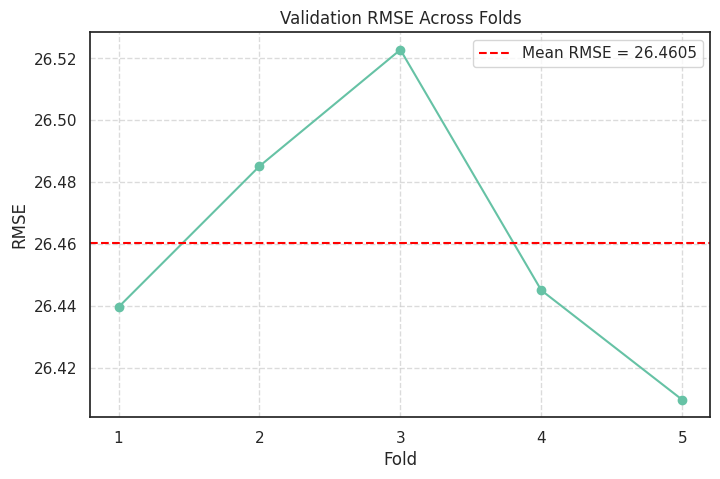

In [19]:
# Plotting validation RMSE across folds
# Converting to numpy array just in case
val_rmses = np.array(val_rmses)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(val_rmses) + 1), val_rmses, marker='o', linestyle='-')
plt.axhline(y=np.mean(val_rmses), color='r', linestyle='--', label=f"Mean RMSE = {np.mean(val_rmses):.4f}")

plt.title("Validation RMSE Across Folds")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.xticks(range(1, len(val_rmses) + 1))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

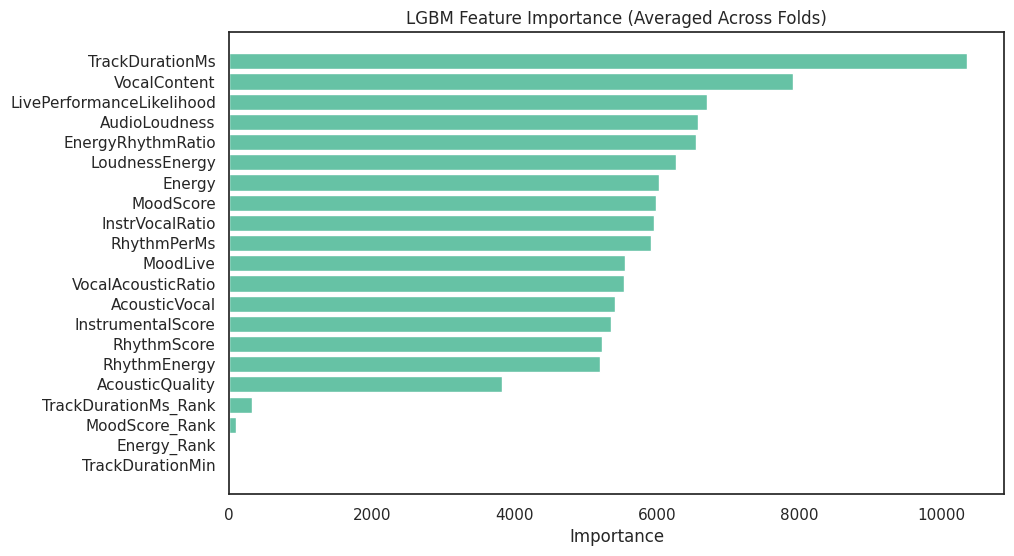

In [20]:
# Plotting feature importance

# Getting feature importances from all folds
feature_importances = np.zeros(X.shape[1])

for model in models:
    feature_importances += model.feature_importances_

# Averaging over folds
feature_importances /= len(models)

# Putting into a DataFrame for sorting/plotting
fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()  # Most important at the top
plt.title("LGBM Feature Importance (Averaged Across Folds)")
plt.xlabel("Importance")
plt.show()

<a id="top"></a>
<a id="6.4"></a>
## **6.4) Model Version Notes**

I have included this section to track the performance of each model version as I attempt to tune/change preprocessing steps and model parameters to obtain a better RMSE. This may also help with reproducibility. 

### **Model 1**

- Notebook Version 7
- Outlier removal technique: Z-score
- Model parameters:
    - n_estimators=20000, learning_rate=0.001, num_leaves=100,
    - max_depth=10, min_child_samples=10, subsample=1.0,
    - colsample_bytree=1.0, reg_alpha=2.0, reg_lambda=1.0
- Mean validation RMSE: 26.343241
- Kaggle RMSE: 26.38907

### **Model 2**
- Notebook Version 8
- Outlier removal technique: None
- Model parameters:
    - Unchanged
- Mean validation RMSE: 26.459605
- Kaggle RMSE: 26.38864

### **Model 3**
- Notebook Version 10
- Outlier removal technique: None
- Model parameters:
    - Unchanged
- Created new features while preserving originals (instead of transforming)
    - SqrtVocalContent, SqrtAcousticQuality
- Mean validation RMSE: 26.459587
- Kaggle RMSE: 26.38899

### **Model 4** (BEST)
- Notebook Version 12
- Outlier removal technique: None
- Model parameters:
    - Unchanged
- Log transformed TrackDurationMs, did not preserve original
- Mean validation RMSE: 26.460504
- Kaggle RMSE: 26.38857

### **Model 5**
- Notebook Version 14
- Outlier removal technique: None
- Model parameters:
    - Tuned with Optuna
- Same preprocessing/feature engineering as Model 4
- Mean validation RMSE: 26.459291
- Kaggle RMSE: 26.38877  

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a id="c"></a>
# **Conclusion/Discussion**

---

Out of all the models, Model 4 had the best RMSE on the Kaggle competition validation data (26.38857). 

Interestingly, Model 4 had the worst RMSE on the notebook validation data (26.460504). This may suggest that while other models perform better on the validation data, they may not generalize as well to the withheld Kaggle validation data. 

It should be noted, however, that the RMSEs of each notebook were all very similar (range of 26.343241 to 26.460504). 

Across all models, TrackDurationMS had the greatest feature importance. 

Future improvements to this project could include:
- Different feature engineering approaches
- Different models (ex: XGBoost)
- Ensembling different models
- Running Optuna trials with different ranges of suggested parameter values

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a id="s"></a>
# **Submission**

---

In [21]:
# Creating submission file, populated with predictions
submission = pd.DataFrame({"id": test["id"], "BeatsPerMinute": y_preds})
submission.to_csv("submission.csv", index=False)

In [22]:
# Viewing first 5 rows of submission dataframe
submission.head()

,id,BeatsPerMinute
0,524164,119.090986
1,524165,118.703210
2,524166,119.009935
3,524167,119.147792
4,524168,119.232824


<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a id="r"></a>
# **References**

---

- Kaggle Competition: https://www.kaggle.com/competitions/playground-series-s5e9/overview
- LightGBM: https://lightgbm.readthedocs.io/en/latest/index.html
- RMSE: https://en.wikipedia.org/wiki/Root_mean_square_deviation
- BPM Prediction Challenge: https://www.kaggle.com/datasets/gauravduttakiit/bpm-prediction-challenge
- Adversarial Validation: https://blog.zakjost.com/post/adversarial_validation/
- KFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- Optuna: https://optuna.org/